In [218]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
def exact_solution(x, omega):
    return np.sin(omega * x) / omega

In [220]:
class FourierLayer(nn.Module):
    def __init__(self, input_dim, num_features):
        super(FourierLayer, self).__init__()
        tensor = torch.arange(input_dim // 2).repeat_interleave(2).unsqueeze(0)
        self.b = nn.Parameter(2 ** tensor * np.pi , requires_grad=False)

    def forward(self, x):
        x_proj = x * self.b
        result_matrix = torch.zeros_like(x_proj)
        for i in range(x_proj.size(0)):
            for j in range(x_proj.size(1)):
                if j % 2 == 0:
                    result_matrix[i][j] = torch.sin(x_proj[i][j])
                else:
                    result_matrix[i][j] = torch.cos(x_proj[i][j])
        return result_matrix

In [221]:
class Network(nn.Module):
    def __init__(self, hidden_layers, hidden_layer_neurons, fourier=False):
        super(Network, self).__init__()
        activation = nn.Tanh
        self.start_layer = nn.Sequential(*[
            nn.Linear(1,hidden_layer_neurons),
            activation()
        ])
        self.hidden_layers = nn.Sequential(
                                *[nn.Sequential(*[nn.Linear(hidden_layer_neurons, hidden_layer_neurons), activation()]) 
            for i in range(hidden_layers)
        ])
        self.hidden_layers = nn.Sequential(
            *[nn.Sequential(*[
                nn.Linear(hidden_layer_neurons, hidden_layer_neurons), activation()
                ]) 
                if not fourier or i == 0 else nn.Sequential(*[FourierLayer(hidden_layer_neurons,hidden_layer_neurons), activation()])for i in range(hidden_layers)
        ])
        self.exit_layer = nn.Linear(hidden_layer_neurons, 1)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.start_layer(x)
        x = self.hidden_layers(x)
        x = self.exit_layer(x)
        return x


In [222]:
def residual_loss(model: Network, x: torch.Tensor, omega: float):
    x = x.requires_grad_(True)
    u = model(x)
    u_x = torch.autograd.grad(u,x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    residual = u_x - torch.cos(omega * x)
    return torch.mean(residual**2)

In [223]:
def ansatz_residual_loss(model: Network, x: torch.Tensor, omega: float):
    x = x.requires_grad_(True)
    u = torch.tanh(omega * x) * model(x)
    u_x = torch.autograd.grad(u,x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    residual = u_x - torch.cos(omega * x)
    return torch.mean(residual**2)

In [224]:
def initial_loss(model: nn.Module):
    u_0 = model(torch.tensor([[0.0]], dtype=torch.float32))
    return torch.mean(u_0**2)

In [225]:
def total_loss(model: nn.Module, x, omega):
    return residual_loss(model=model, x=x, omega=omega) + initial_loss(model=model)

In [230]:
def learn(omega, t_points, hidden_layers, neurons, loss_fun, lr=0.001, epochs=50000, fourier=False) -> Network:
    domain = np.linspace(-2 * np.pi, 2*np.pi, t_points).reshape(-1,1)
    model = Network(hidden_layers=hidden_layers, hidden_layer_neurons=neurons, fourier=fourier)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    x_tensor = torch.tensor(domain, dtype=torch.float32)
    loss_buff = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_fun(model, x_tensor, omega)
        loss.backward()
        loss_buff.append(loss)
        optimizer.step()
        print(epoch)
    pd.DataFrame(np.array(loss_buff), columns=["epoch", "loss"]).to_csv(f"{omega}-{t_points}-{hidden_layers}-{neurons}-{fourier}.csv")
    return model


In [227]:
def predict(model: nn.Module, domain):
    x_tensor = torch.tensor(domain, dtype=torch.float32)
    return model(x_tensor).detach().numpy()

# Modele

### $\omega=1$

In [31]:
m1 = learn(omega=1, t_points=200,hidden_layers=2,neurons=16, loss_fun=total_loss)

In [32]:
m2 = learn(omega=1, t_points=200, hidden_layers=4, neurons=64, loss_fun=total_loss)

In [33]:
m3 = learn(omega=1, t_points=200, hidden_layers=5, neurons=128, loss_fun=total_loss)

In [58]:
torch.save(m1.state_dict(),"m1.pth")

In [59]:
torch.save(m2.state_dict(), "m2.pth")

In [60]:
torch.save(m3.state_dict(), "m3.pth")

### Testy

In [51]:
test_points_A = 1000

test_domain_A = np.linspace(-2*np.pi, 2*np.pi, test_points_A).reshape(-1,1)

u_true = exact_solution(x=test_domain_A, omega=1)

In [41]:
m1_pred = predict(model=m1, domain=test_domain_A)
m2_pred = predict(model=m2, domain=test_domain_A)
m3_pred = predict(model=m3, domain=test_domain_A)

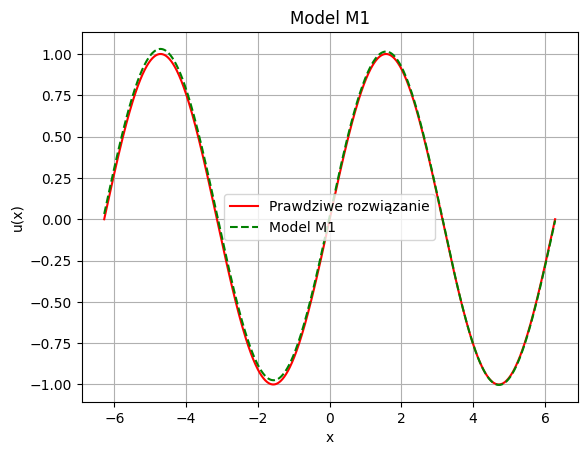

In [45]:
plt.plot(test_domain_A, u_true, label="Prawdziwe rozwiązanie", color="red")
plt.plot(test_domain_A, m1_pred, label="Model M1", linestyle="dashed", color="green")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Model M1")
plt.show()

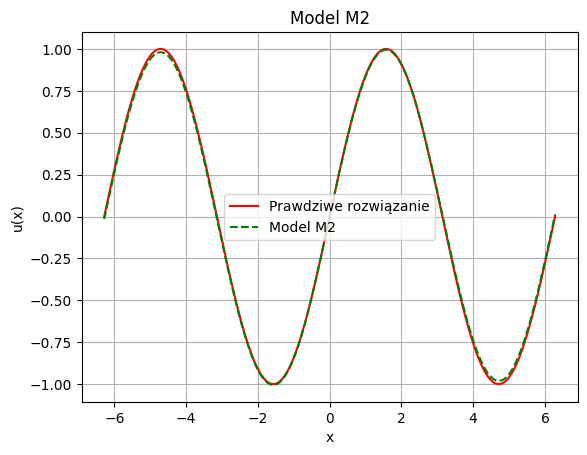

In [46]:
plt.plot(test_domain_A, u_true, label="Prawdziwe rozwiązanie", color="red")
plt.plot(test_domain_A, m2_pred, label="Model M2", linestyle="dashed", color="green")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Model M2")
plt.show()

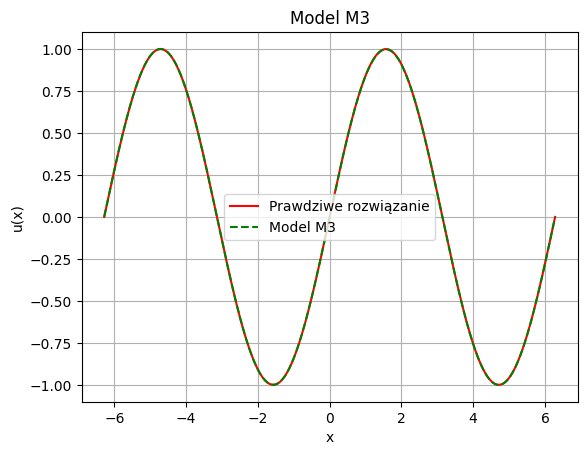

In [47]:
plt.plot(test_domain_A, u_true, label="Prawdziwe rozwiązanie", color="red")
plt.plot(test_domain_A, m3_pred, label="Model M3", linestyle="dashed", color="green")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Model M3")
plt.show()

### $\omega=15$

In [48]:
m4 = learn(omega=15,t_points=3000, hidden_layers=2, neurons=16, loss_fun=total_loss)

In [49]:
m5 = learn(omega=15,t_points=3000, hidden_layers=4, neurons=64, loss_fun=total_loss)

In [50]:
m6 = learn(omega=15, t_points=3000, hidden_layers=5,neurons=128, loss_fun=total_loss)

In [61]:
torch.save(m4.state_dict(), "m4.pth")

In [62]:
torch.save(m5.state_dict(), "m5.pth")

In [63]:
torch.save(m6.state_dict(), "m6.pth")

##### Testy

In [52]:
test_points_B = 5000

test_domain_B = np.linspace(-2*np.pi, 2*np.pi, test_points_B).reshape(-1,1)

u_true = exact_solution(x=test_domain_B, omega=15)

In [53]:
m4_pred = predict(m4, test_domain_B)
m5_pred = predict(m5, test_domain_B)
m6_pred = predict(m6, test_domain_B)

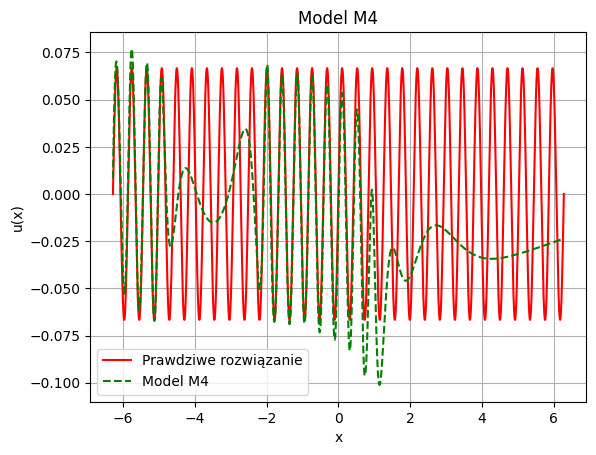

In [55]:
plt.plot(test_domain_B, u_true, label="Prawdziwe rozwiązanie", color="red")
plt.plot(test_domain_B, m4_pred, label="Model M4", linestyle="dashed", color="green")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Model M4")
plt.show()

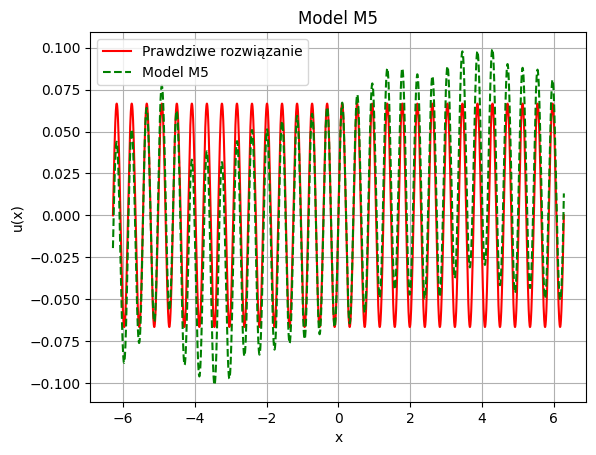

In [56]:
plt.plot(test_domain_B, u_true, label="Prawdziwe rozwiązanie", color="red")
plt.plot(test_domain_B, m5_pred, label="Model M5", linestyle="dashed", color="green")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Model M5")
plt.show()

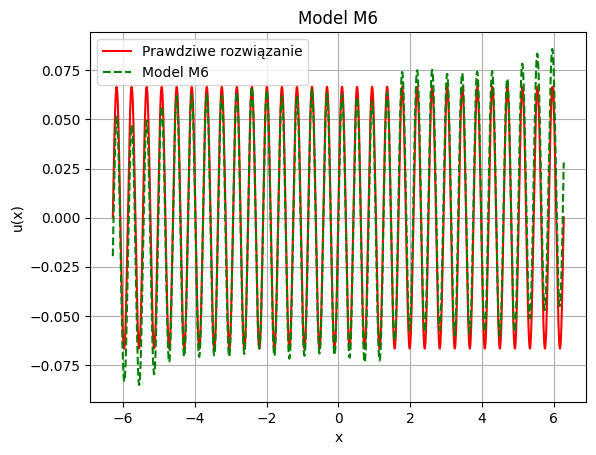

In [57]:
plt.plot(test_domain_B, u_true, label="Prawdziwe rozwiązanie", color="red")
plt.plot(test_domain_B, m6_pred, label="Model M6", linestyle="dashed", color="green")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Model M6")
plt.show()

In [66]:
m7 = learn(omega=15,t_points=3000, hidden_layers=2, neurons=16, loss_fun=ansatz_residual_loss)

In [67]:
torch.save(m7.state_dict(),"m7.pth")

##### Testy

In [69]:
m7_pred = predict(m7, test_domain_B)

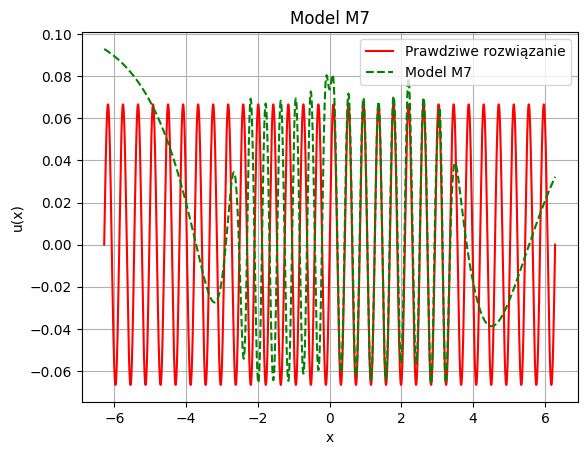

In [70]:
plt.plot(test_domain_B, u_true, label="Prawdziwe rozwiązanie", color="red")
plt.plot(test_domain_B, m7_pred, label="Model M7", linestyle="dashed", color="green")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Model M7")
plt.show()

### Fourier

In [231]:
m8 = learn(omega=15,t_points=3000, hidden_layers=2, neurons=16, loss_fun=total_loss, fourier=True)

0
1
2


KeyboardInterrupt: 

In [ ]:
torch.save(m8.state_dict(), "m8v1.pth")

In [132]:
m8_pred = predict(m8,test_domain_B)

In [171]:
m8v2_pred = predict(m8, test_domain_B)

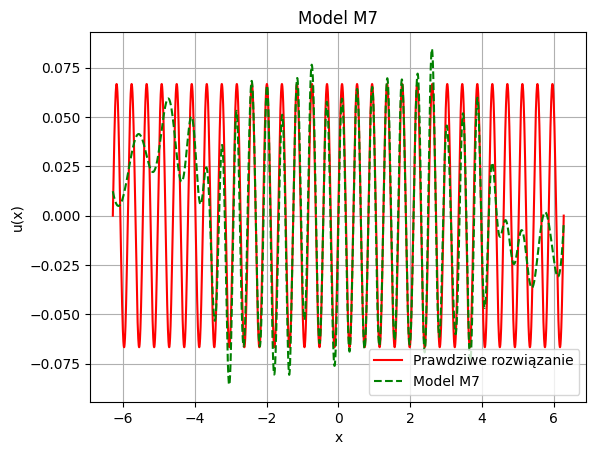

In [133]:
plt.plot(test_domain_B, u_true, label="Prawdziwe rozwiązanie", color="red")
plt.plot(test_domain_B, m8_pred, label="Model M7", linestyle="dashed", color="green")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Model M7")
plt.show()